# Latencies with Cache Coherency states on one Socket, Conway, I/O-die in P-state auto, DRAM @ 1467MHz

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})

## Define functions

In [2]:
# taken from https://github.com/kuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, startstring, searchpara, retlist):

    searchpara = searchpara + "\""
    
    for file in filelist:
        for line in open(file):
            if line.startswith(startstring):
                if searchpara in line:
                    retlist.append(file)

In [4]:
def evaluation(filelist, core, size):
    
    csvvalues = numpy.array([])
    datapoints = numpy.array([])
    evaluation_vals = numpy.array([])


    # use measurements for same core from run with core 1
    if core == "0":
        coreline = "BENCHIT_KERNEL_CPU_LIST=\"0,1"
    else:
        coreline = "BENCHIT_KERNEL_CPU_LIST=\"0," + core + "\""

    core_found = False
    data_found = False


    # iterate over lines in file
    for file in filelist:

        # empty arrays
        csvvalues = numpy.array([])
        datapoints = numpy.array([])

        core_found = False
        data_found = False

        for line in open(file):
                    
            # check if file has data for core
            if line.startswith(coreline):
                core_found = True

            # data begins after "beginofdata" string, only search for this when coreline has been found in file
            if line.startswith("beginofdata") and core_found == True:
                data_found = True

            # append data to values array, make sure that no strings are appended
            if data_found == True and not line.startswith("endofdata") and not line.startswith("beginofdata"):
                
                # data for core 0 is taken from file that contains data for cores 0,1
                # data for core 0 can be found in col. index 1, every other core in col. index 2
                if core == "0":
                    csvvalues = numpy.append(csvvalues, float(line.split()[1]))
                else:
                    csvvalues = numpy.append(csvvalues, float(line.split()[2]))

                # append data sizes
                datapoints = numpy.append(datapoints, str(line.split()[0]))

        # process data only when wanted data has been found in file
        if data_found == True:

            # find data size string in datapoints array
            index = numpy.where(datapoints == size)
            
            # save latency value for given data size and next 4 values to array
            for i in range(4):
                evaluation_vals = numpy.append(evaluation_vals, csvvalues[index[0] + i])

    # calculate median
    # save min and max value as error
    median = numpy.average(evaluation_vals)
    stdevs = numpy.std(evaluation_vals)
    maximum = abs(max(evaluation_vals) - median)
    minimum = abs(min(evaluation_vals) - median)

    return(median, stdevs, maximum, minimum)

In [12]:
# plotter function
def plotter(medians, stdevs, level, machine):
   
    # print values on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 8+height,
                    '%d (%.1f)' % (round(height), float(height/2.5)),
                rotation=90, ha='center', va='bottom', size='x-small')

    #fig, ax = plt.subplots(1, 1, figsize=set_size(455.24408, fraction=0.7))
    fig, ax = plt.subplots()
    
    levels = ['L1', 'L2', 'L3', 'RAM']
    # set title according to memory level, CPU architecture, machine designation
    ax.set_title(levels[level] + ' Latency, on 2x' + machine + ', DRAM @ 1466MHz\n'+
                 'I/O-die in P-state auto', fontsize='x-large')
    
    xlabels = numpy.array(['Node 0', 'Node 1', 'Node 2', 'Node 3', 'Node 4', 'Node 5', 'Node 6', 'Node 7'])
    
    # as many x-ticks as memory locations
    x = numpy.arange(len(xlabels))
    ax.set_xlabel('Memory Location', fontsize='x-large')

    # use instructions as xticks
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=45, ha='right', rotation_mode='anchor') 

    ax.set_ylabel('Latency in [cycles]', fontsize='x-large')
    
    # enable y-axis grid
    ax.grid(b=True, which='major', axis='y', linestyle='--', linewidth='0.4')
    
    ax.axvline(x=3.5, color='grey', linestyle="--")
                
    width = 0.7
    rect1 = ax.bar(x,  medians, width, yerr=stdevs, xerr=0)
    autolabel(rect1)
    # set y axis limit identical for all plots for consistent looks & fitting bar labels
    ax.set_ylim(bottom=0, top=round(max(\
                              numpy.max(medians),\
                              numpy.max(medians) * 1.9)))
    
    # secondary y-axis
    def cyctons(y):
        return y * 2.5
    
    def nstocyc(y):
        return y/2.5
    secax = ax.secondary_yaxis('right', functions =(nstocyc, cyctons)) 
    secax.set_ylabel('Latency in [ns]', fontsize='x-large') 
    # ensure that xticks-labels are being shown on saved plot
    fig.tight_layout()
        
    # save plot to file
    filename = machine+'-Latencies-'+levels[level]+'-Pauto-DRAM_1466MHz-print.png'

    matplotlib.pyplot.savefig(filename, dpi=300, format='png') 
    print(filename + ' has been saved to disk.')


## Create file lists

In [6]:
# get list of all files in directory
path = 'datafiles'

filelist = []

for entry in log_progress(os.scandir(path), True): 
    filelist.append(entry.path)

In [7]:
files = [] # 0 = M, 1 = (E|U), 2 = S, 3 = E, 4 = I

states = ['I']

for state in log_progress(states):
    index = states.index(state)
    
    listgenerator(filelist, 'BENCHIT_KERNEL_USE_MODE', state, files)
    
    print("Files in list for state " + str(state) + ": " + str(len(files)))

Files in list for state I: 80


## Process data

In [8]:
#datasize = ['21893', '122866', '6.19382e+06', '6.50839e+07']
size = '3.06366e+07'

cores = ['1', '8', '16', '28', '32', '40', '48', '56']

medians = numpy.zeros([len(cores)]) # States, Datasizes, Cores
stdevs = numpy.zeros([len(cores)])
maxima = numpy.zeros([len(cores)])
minima = numpy.zeros([len(cores)])

for core in log_progress(cores):
    core_index = cores.index(core)

    medians[core_index], \
    stdevs[core_index],\
    maxima[core_index],\
    minima[core_index] = \
    evaluation(files, core, size)

## Plot data

AMD EPYC 7502-Latencies-RAM-Pauto-DRAM_1466MHz-print.png has been saved to disk.


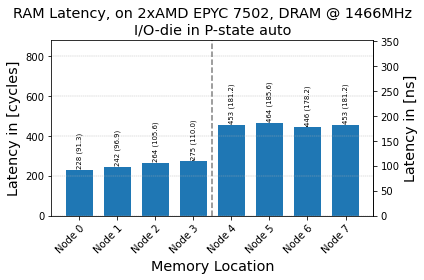

In [13]:
plotter(medians, stdevs, 3, 'AMD EPYC 7502')